In [62]:
from src import *

from nilearn.connectome import ConnectivityMeasure

In [63]:
def scaled_sigmoid(x, smin, smax, saturation_point=0.95, eps=0.2):
    b = smax - (smax - smin)/2
    a = (b - smax) / np.log(1/saturation_point - 1)
    sx = (b-x)/a
    A = smin + smin * eps
    K = smax + smax * eps
    return A + (K-A) / (1 + np.exp(sx))

def scaled_sigmoid_torch(x, smin, smax, saturation_point=0.95, eps=0.2):
    b = smax - (smax - smin)/2
    a = (b - smax) / np.log(1/saturation_point - 1)
    sx = (b-x)/a
    A = smin + smin * eps
    K = smax + smax * eps
    return A + (K-A) / (1 + torch.exp(sx))

# sat_min, sat_max = -100, 40
# tmp = np.linspace(sat_min-50, sat_max+50, 1000)
# plt.plot(tmp, scaled_sigmoid(tmp, sat_min, sat_max, saturation_point=0.95))
# plt.hlines(-120, xmin=-150, xmax=100, linestyle='--', color='k')
# plt.hlines(48, xmin=-150, xmax=100, linestyle='--', color='k')
# plt.vlines(-150, ymin=-125, ymax=50, linestyle='--', color='r')
# plt.vlines(100, ymin=-125, ymax=50, linestyle='--', color='r')

# # Small check for the distribution of min max activity
# tmp = np.array([[region_ftimecourse[k].min(), region_ftimecourse[k].max()] for k in range(len(region_ftimecourse))])
# plt.scatter(np.abs(tmp[:,0]), tmp[:,1])

def plot_compare_inpainting(list_inpaintings, coords_of_interest, affines, inpaint_names, vmin=-1, vmax=1, draw_cross=False):
    """
    Compare the inpaintings by plotting various of them at different slice of interest
    """
    r = len(list_inpaintings)
    nbc = 3
    if r % nbc == 0:
        nbr = r//nbc
    else:
        nbr = r//nbc + 1
    fig, ax = plt.subplots(nbr,nbc, figsize=(8*nbc,5*nbr), facecolor='black')
    cmap = mpl.colormaps.get_cmap('jet')
    cmap.set_extremes(under='black', over='black')
    
    for r in range(nbr):
        for c in range(nbc):
            idx = r * nbc + c
            if nbr == 1: 
                plot_epi(nib.Nifti1Image(list_inpaintings[idx], affine=affines[idx]),colorbar=True, 
                         cut_coords=coords_of_interest[idx], axes=ax[c], cmap=cmap, vmin=vmin, vmax=vmax, draw_cross=draw_cross)
                ax[c].set_title(inpaint_names[idx], color='white')
            else:
                plot_epi(nib.Nifti1Image(list_inpaintings[idx], affine=affines[idx]),colorbar=True, 
                         cut_coords=coords_of_interest[idx], axes=ax[r,c], cmap=cmap, vmin=vmin, vmax=vmax, draw_cross=draw_cross)
                ax[r,c].set_title(inpaint_names[idx], color='white')

    plt.suptitle(f'Bundle {int(np.ceil(thresh_subjapp))}% of subjects', color='white')

def compute_directed_laplacian(A):
    """
    Desc: compute directed laplacian in-degrees for the D matrix
    Inputs: A -> adjacency matrix
    Returns: ret -> directed laplacian
    """
    
    # Compute indegrees
    indeg = A.sum(axis=0).astype(float)
    ret = np.diag(indeg) - A.astype(float)
    
    return ret


def make_cycle(N):
    A = np.diag(np.ones(N-1))
    A = np.concatenate([A,np.zeros((1,N-1))])
    bound = np.zeros((N,1))
    bound[-1] = 1.0
    A = np.concatenate([bound, A], axis=1)
    return A


def optimize_lreg(ywhite, X, y, Ls, Lt, num_epochs=1000, 
                  lr=1e-3, seed=99, verbose=False, p1=10.0,
                    p2=10.0, logging=False, saturate=False, saturate_factor=0.95, positive_constraint=False):
    """
    Optimize linear regression parameters with property based regularizers.

    Args:
    - y: Full fMRI timecourse for all regions (#regions, #timepoints) 
    - X: Bundle encoding matrix (#bundles, #regions)
    - Ls: Spatial Laplacian across bundles
    - Lt: Temporal Laplacian across regions at bundles
    - num_epochs: Number of training epochs
    - lr: Learning rate 
    - seed: Random seed 
    - verbose: Print progress
    - p1: Weight for spatial regularizer
    - p2: Weight for temporal regularizer
    
    Returns:
    - pred_activity: Predicted bundle activities
    - logging_dict: Dictionary containing loss values per epoch (optional)
    """
    torch.manual_seed(seed)

    loss_func = nn.MSELoss()
    optimizer = torch.optim.Adam([ywhite], lr=lr)

    if logging:
        logging_dict = {'gen_loss': [],'spatial_reg_loss': [], 'temporal_reg_loss': [], 'positiveness_reg_loss': [], 'total_loss': []}
    if saturate:
        lbound, rbound = y.min(axis=1).values, y.max(axis=1).values

    for _ in tqdm(range(num_epochs), disable=(not verbose)):
        # Looping within epochs across time and space
        
        # Compute datafit loss (saturate flag -> allows for saturation of individual bundles' activities)
        generic_loss = torch.zeros(1)
        for tidx in range(X.shape[0]):
            y_pred = X[tidx] @ ywhite[tidx]
            if saturate:
                for ridx in range(y_pred.shape[0]):
                    y_pred[ridx] = scaled_sigmoid_torch(y_pred[ridx], lbound[ridx].item(), rbound[ridx].item(),
                                                         saturation_point=saturate_factor)

            genloss = loss_func(y_pred, y[tidx])
            generic_loss += genloss
        logging_dict['gen_loss'].append(generic_loss.detach().item())

        # Add regularizer considering spatial smoothness of bundles
        spatialreg_loss = torch.zeros(1)
        for tidx in range(X.shape[0]):
            spatialreg_loss += torch.linalg.norm(Ls @ ywhite[tidx])
        logging_dict['spatial_reg_loss'].append(spatialreg_loss.detach().item())

        # Add regularizer considering temporal smoothness of each bundles
        temporalreg_loss = torch.zeros(1)
        for tidx in range(X.shape[0]):
            temporalreg_loss += torch.linalg.norm(Lt @ ywhite[:, tidx])
        logging_dict['temporal_reg_loss'].append(temporalreg_loss.detach().item())

        sumloss = generic_loss + p1 * spatialreg_loss + p2 * temporalreg_loss

        # # Regularization on positive weights
        # if positive_constraint:
        #     negative_loss = torch.zeros(1)
        #     for tidx in range(X.shape[0]):
        #         negative_loss += torch.sum((ywhite[tidx] < 0) * torch.abs(ywhite[tidx]))
        #     logging_dict['positiveness_reg_loss'].append(negative_loss.detach().item())

        #     sumloss += negative_loss

        logging_dict['total_loss'].append(sumloss.detach().item())
        optimizer.zero_grad()
        sumloss.backward()
        optimizer.step()

    if verbose:
        print(f'Losses are decomposed into:')
        print(f'generic loss={generic_loss.detach()}')
        print(f'spatialloss={spatialreg_loss.detach()}')
        print(f'temporalloss={temporalreg_loss.detach()}')
        print(f'sumloss={sumloss.detach()}')
        # if positive_constraint:
        #     print(f'positivenessloss={negative_loss.detach()}')

    if positive_constraint:
        ywhite = (ywhite > 0) * ywhite
        
    pred_activity = ywhite.detach().numpy()

    if logging:
        return pred_activity, logging_dict
    else:
        return pred_activity

## Goal

The goal of this notebook is to do inpainting. Allowing for negative weightings of bundle to generate bundles, and allowing as well negatively connected bundles to exist

## Description



- Scale1 -> ~95
- Scale2 -> ~140
- Scale3 -> ~240

Structuring of folder h5: 
- ['atlas', 'header', 'matrices']:
    - atlas:
        - bundles 10-59
        - bundles 11-23
        - ...
    - header: 
        - affine, dim, gmcodes, gmcolors, gmcoords, gmregions, nsubjects, voxsize
    - matrices:
        - consistency
        - length
        - numbStlines

In [64]:
connFilename = '../atlas_data/fiber_atlas/probconnatlas/wm.connatlas.scale1.h5'
hf = h5py.File(connFilename, 'r')

In [65]:
centers = np.array(hf.get('header').get('gmcoords'))
nsubject = hf.get('header').get('nsubjects')[()]
dim = hf.get('header').get('dim')[()]
fiber_affine = hf.get('header').get('affine')[()]

gmregions_names = hf.get('header').get('gmregions')[()]
nb_regions = gmregions_names.shape[0]
# use the masks if necessary when we select too much bundles for reconstruction
gm_mask_subj = nib.load('../atlas_data/rstfMRI_eg/gm_mask_subj7.nii').get_fdata()
wm_mask_subj = (gm_mask_subj + 1) % 2

In [108]:
consistency_view = get_aggprop(hf, 'consistency')
length_view = get_aggprop(hf, 'length')
nbStlines_view = get_aggprop(hf, 'numbStlines')
nb_regions = consistency_view.shape[0]

In [66]:
region_of_interest = ['ctx-rh-posteriorcingulate', 'ctx-lh-posteriorcingulate']
index_of_interest = [np.where(gmregions_names.astype(str) == r)[0][0] 
                     for r in region_of_interest]

index_of_interest = np.array(index_of_interest)
gmregions_names[index_of_interest]

array([b'ctx-rh-posteriorcingulate', b'ctx-lh-posteriorcingulate'],
      dtype='|S49')

### Regressing Bundle Activities

In [67]:
thresh_subjapp = int(np.ceil(nsubject * 0.1)) # consider bundles that appear at least in 30 % of the subjects

In [41]:
# Generating the X samples and the y samples
# 1. Careful as well to remove the auto-correlation in the diagonal
# 2. Raster scan parsing meaning that it is the activity of (R0,R1) -> (R0,R2) -> (R0,R3) etc...
# Define matrix of end points on cortex
X = []
bundles_labels = []
# pairs = np.zeros((nb_regions, nb_regions))
for i in tqdm(range(1,nb_regions + 1)):
    for j in range(i,nb_regions + 1):
        tmp = get_bundles_betweenreg(hf, i, j, verbose=False)
        if tmp is None: continue
        if np.sum(tmp[:,3] >= (thresh_subjapp)) == 0: continue
        bundles_labels.append((i,j))
        # pairs[i-1,j-1] = 1.0
        vec = np.zeros(nb_regions)
        vec[i-1] = 1.0
        vec[j-1] = 1.0
        X.append(vec)

X = np.asarray(X)
X_norm = (np.diag(1/X.sum(axis=0)) @ X.T).T

100%|██████████| 95/95 [00:24<00:00,  3.91it/s]


In [42]:
# Region's actual activity for interpolation
region_ftimecourse = load("../atlas_data/rstfMRI_eg/yasseratlased_fmri/ftimecourse_95.pkl")
regions_in_voxels = load('../atlas_data/fiber_atlas/regions95_voxels.pkl')[:,:,:,1:]

#### Regressing L1 - L2

In [23]:
# Ridge
regularizers = np.sort(np.concatenate([np.logspace(0,5,6), np.logspace(0,5,6) / 2]))

perf_ridge = {'coefs': [],'scores': [], 'intercepts': []}
for tidx in tqdm(range(region_ftimecourse.shape[1])):
    y = region_ftimecourse[:,tidx]
    coefs = []
    scores = []
    intercepts = []
    for k in range(len(regularizers)):
        clf = Ridge(alpha=regularizers[k])
        clf.fit(X.T, y)
        scores.append(((clf.predict(X.T) - y) ** 2).mean())
        coefs.append(clf.coef_)
        intercepts.append(clf.intercept_)

    perf_ridge['coefs'].append(coefs)
    perf_ridge['scores'].append(scores)
    perf_ridge['intercepts'].append(intercepts)

# Lasso
regularizers_lasso = np.sort(np.concatenate([np.logspace(-5,0,6), np.logspace(-5,0,6) / 2]))
perf_lasso = {'coefs': [],'scores': [], 'intercepts': []}

for tidx in tqdm(range(region_ftimecourse.shape[1])):
    y = region_ftimecourse[:,tidx]
    coefs = []
    scores = []
    intercepts = []
    for k in range(len(regularizers_lasso)):
        clf = Lasso(alpha=regularizers_lasso[k])
        clf.fit(X.T, y)
        scores.append(((clf.predict(X.T) - y) ** 2).mean())
        coefs.append(clf.coef_)
        intercepts.append(clf.intercept_)
    
    perf_lasso['coefs'].append(coefs)
    perf_lasso['scores'].append(scores)
    perf_lasso['intercepts'].append(intercepts)

  0%|          | 0/460 [00:00<?, ?it/s]/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.073e+01, tolerance: 7.219e+00
  model = cd_fast.enet_coordinate_descent(
/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.678e+01, tolerance: 7.219e+00
  model = cd_fast.enet_coordinate_descent(
/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You

In [284]:
# scalenorm = np.abs(region_ftimecourse).mean()
# plt.hist(np.array(perf_lasso['scores'])[:,0] / scalenorm, alpha=0.3)
# plt.hist(np.array(perf_lasso['scores'])[:,1] / scalenorm, alpha=0.3)
# plt.hist(np.array(perf_lasso['scores'])[:,2] / scalenorm, alpha=0.3)
# plt.hist(np.array(perf_lasso['scores'])[:,3] / scalenorm, alpha=0.3)
# plt.hist(np.array(perf_lasso['scores'])[:,5] / scalenorm, alpha=0.3)

# plt.xscale('log')

#### Generating time varying vertex graph
The rational generating time varying vertex graph is to exploit time relationship in fMRI.

Graph generation conditions:
- The nodes are the atlased regions while the edges are connected when bundles have a commonly shared region
- We then duplicate such a graph in time

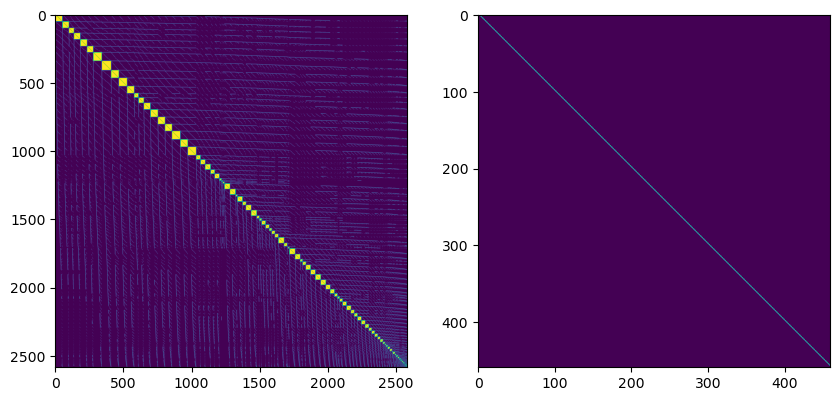

In [44]:
# spatial graph defining
bundle_graph = np.zeros((X.shape[0], X.shape[0]))
for k in range(X.shape[0]):
    avect1 = X[k]
    for s in range(X.shape[0]):
        if s == k: continue
        avect2 = X[s]
        if np.abs(avect1 - avect2).sum() <= 2:
            bundle_graph[k,s] = 1.0
            bundle_graph[s,k] = 1.0

# temporal graph defining
cycle = make_cycle(region_ftimecourse.shape[-1])

Ls = compute_directed_laplacian(bundle_graph)
Lt = compute_directed_laplacian(cycle)

fig, ax = plt.subplots(1,2, figsize=(10, 10))

ax[0].imshow(bundle_graph)
ax[1].imshow(cycle)

In [70]:
# duplication of X and keep y as it is
Xmult = np.array([X.T for _ in range(region_ftimecourse.shape[-1])])
ywhite_init = np.random.random((region_ftimecourse.shape[1], X.shape[0])) - 0.5

# Converting np arrays into Torchs
Xtorch = torch.Tensor(Xmult)
ytorch = torch.Tensor(region_ftimecourse.T)
whitetorch = torch.Tensor(ywhite_init).requires_grad_(True) ; Lstorch = torch.Tensor(Ls) ; Lttorch = torch.Tensor(Lt)

bundle_opt, logs = optimize_lreg(whitetorch, Xtorch, ytorch, Ls=Lstorch, Lt=Lttorch, 
                                 verbose=True, num_epochs=200, logging=True, p1=1e-1, p2=1e-1, lr=1)

ywhite_init = np.random.random((region_ftimecourse.shape[1], X_norm.shape[0])) - 0.5
Xtorch = torch.Tensor(Xmult)
ytorch = torch.Tensor(region_ftimecourse.T)
whitetorch = torch.Tensor(ywhite_init).requires_grad_(True) ; Lstorch = torch.Tensor(Ls) ; Lttorch = torch.Tensor(Lt)

bundle_opt_saturate, logs_saturate = optimize_lreg(whitetorch, Xtorch, ytorch, Ls=Lstorch, Lt=Lttorch, 
                                 verbose=True, num_epochs=200, logging=True, p1=1e-1, p2=1e-1, lr=1, saturate=True, saturate_factor=0.85)

100%|██████████| 200/200 [05:00<00:00,  1.50s/it]


Losses are decomposed into:
generic loss=tensor([8075.4697])
spatialloss=tensor([249325.5625])
temporalloss=tensor([1848.1257])
sumloss=tensor([33192.8398])


100%|██████████| 200/200 [17:09<00:00,  5.15s/it]


Losses are decomposed into:
generic loss=tensor([16949.9746])
spatialloss=tensor([245940.2188])
temporalloss=tensor([1839.6931])
sumloss=tensor([41727.9648])


0.025371783535096434
0.017512589514404063


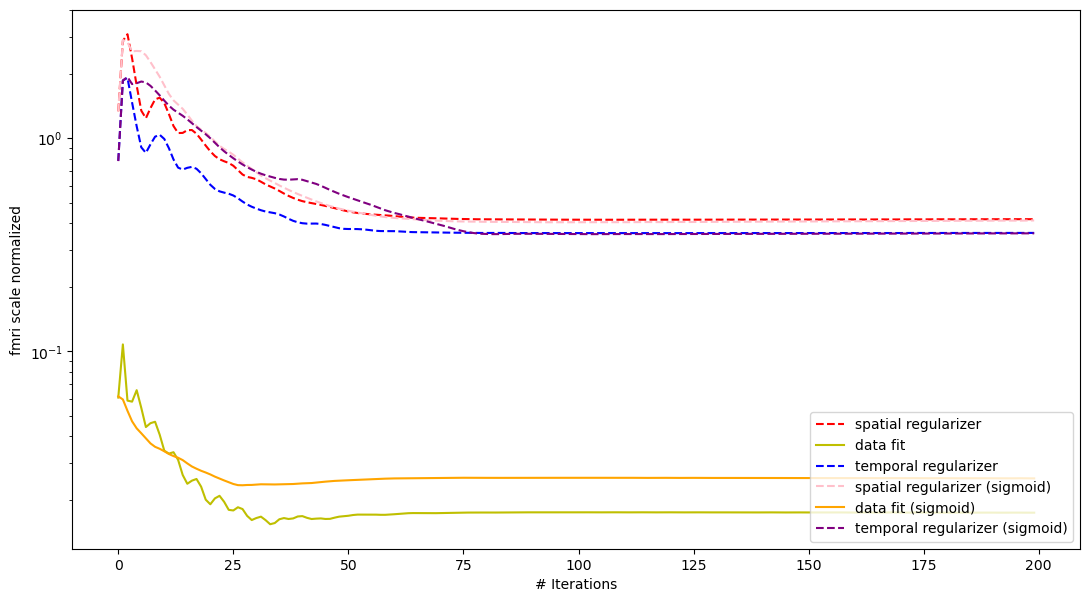

In [71]:
scalenorm = np.abs(region_ftimecourse).mean()
meandeg = bundle_graph.sum(axis=0).astype(float).mean()

datafit_loss = np.sqrt(np.array(logs['gen_loss'])) / region_ftimecourse.shape[-1] / scalenorm
spatial_reg_loss = np.array(logs['spatial_reg_loss']) / (bundle_opt.shape[0] * meandeg) / scalenorm 
temporal_reg_loss = np.array(logs['temporal_reg_loss']) / region_ftimecourse.shape[-1] / scalenorm

datafit_loss_sat = np.sqrt(np.array(logs_saturate['gen_loss'])) / region_ftimecourse.shape[-1] / scalenorm
spatial_reg_loss_sat = np.array(logs_saturate['spatial_reg_loss']) / (bundle_opt.shape[0] * meandeg) / scalenorm 
temporal_reg_loss_sat = np.array(logs_saturate['temporal_reg_loss']) / region_ftimecourse.shape[-1] / scalenorm

time_horizon = 200
plt.figure(figsize=(13,7))
plt.plot(spatial_reg_loss[:time_horizon], color='r', linestyle='--', label='spatial regularizer')
plt.plot(datafit_loss[:time_horizon], color='y', label='data fit')
plt.plot(temporal_reg_loss[:time_horizon], color='b', linestyle='--', label='temporal regularizer')

plt.plot(spatial_reg_loss_sat[:time_horizon], color='pink', linestyle='--', label='spatial regularizer (sigmoid)')
plt.plot(datafit_loss_sat[:time_horizon], color='orange', label='data fit (sigmoid)')
plt.plot(temporal_reg_loss_sat[:time_horizon], color='purple', linestyle='--', label='temporal regularizer (sigmoid)')
plt.legend(loc='lower right')
plt.yscale('log')
plt.ylabel('fmri scale normalized')
plt.xlabel('# Iterations')
print(datafit_loss_sat[-1])
print(datafit_loss[-1])

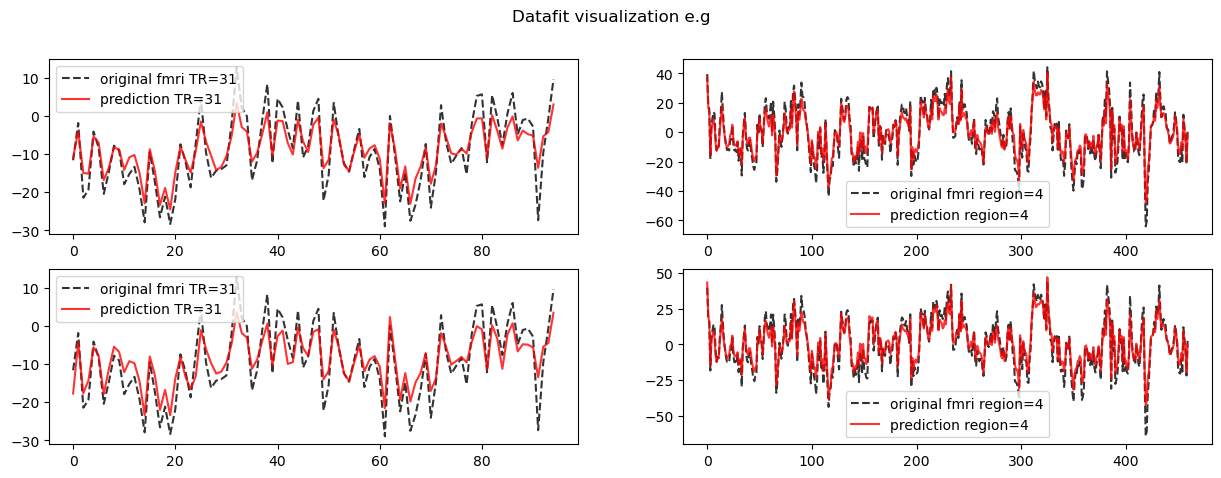

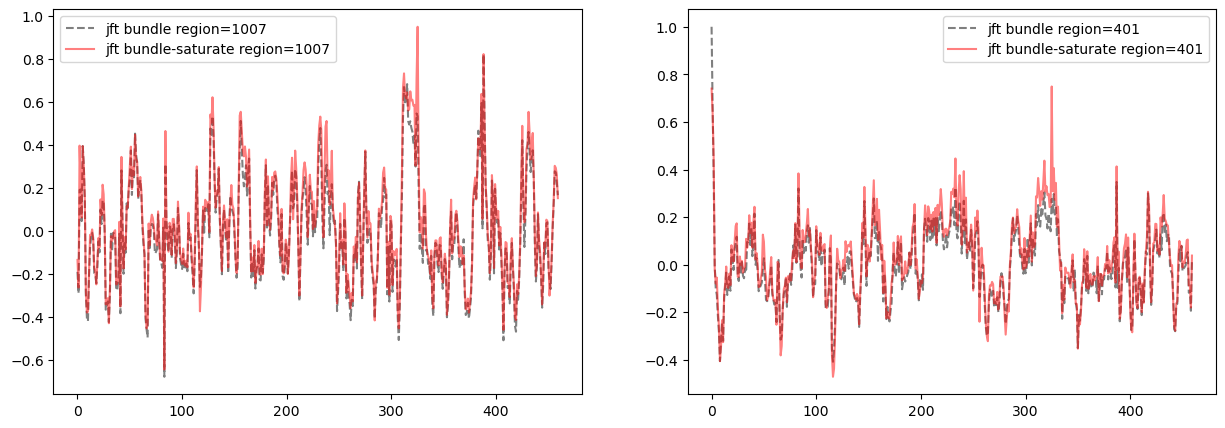

In [72]:
fig, ax = plt.subplots(2,2, figsize=(15,5))
cidx = 30
plt.suptitle('Datafit visualization e.g')
for pidx in range(2):
    bundle = [bundle_opt, bundle_opt_saturate][pidx]
    ax[pidx, 0].plot(region_ftimecourse[:, cidx], c='k', linestyle='--', label=f'original fmri TR={cidx+1}', alpha=0.8)
    tmp = torch.Tensor(Xmult[cidx] @ bundle[cidx])
    ax[pidx, 0].plot(tmp, c='r', label=f'prediction TR={cidx+1}', alpha=0.8)
    ax[pidx, 0].legend()

    vidx = 3

    rec_timecourse = np.zeros((len(Xmult)))
    for k in range(len(Xmult)):
        tmp = Xmult[k] @ bundle[k]
        rec_timecourse[k] = tmp[vidx]

    ax[pidx, 1].plot(region_ftimecourse[vidx], c='k', linestyle='--', label=f'original fmri region={vidx+1}', alpha=0.8)
    ax[pidx, 1].plot(rec_timecourse, c='r', label=f'prediction region={vidx+1}', alpha=0.8)
    ax[pidx, 1].legend()


fig, ax = plt.subplots(1,2, figsize=(15,5))
vidx = [1006, 400]

for k in range(2):
    # ax[k].plot(np.array(perf_ridge['coefs'])[:,3,vidx[k]], c='r', label=f'ridge bundle region={vidx[k]+1}', alpha=0.8)
    # ax[k].plot(range11(np.array(perf_lasso['coefs'])[:,3,vidx[k]]), c='b', label=f'lasso bundle region={vidx[k]+1}', alpha=0.3)
    ax[k].plot(bundle_opt[:,vidx[k]], c='k', label=f'jft bundle region={vidx[k]+1}', alpha=0.5, linestyle='--')
    ax[k].plot(bundle_opt_saturate[:,vidx[k]], c='r', label=f'jft bundle-saturate region={vidx[k]+1}', alpha=0.5)
    ax[k].legend()
    # ax[k].set_yscale('log')

plt.show()

In [610]:
save(f"./resources/weight_regressors_activity/bundle_activity_lasso{thresh_subjapp}.pkl", perf_lasso)
save(f"./resources/weight_regressors_activity/bundle_activity_ridge{thresh_subjapp}.pkl", perf_ridge)
save(f"./resources/weight_regressors_activity/bundle_activity_timevertex{thresh_subjapp}.pkl", bundle_opt)
save(f"./resources/weight_regressors_activity/bundle_activity_timevertex_saturate{thresh_subjapp}.pkl", bundle_opt_saturate)

### Hyperparameters Optimization
- Train / Test split: 80% / 20%
    - use direct loss values
    - use FC similarity of train reconstruction and val reconstruction

In [704]:
split_ratio = 0.8
train_size = int(split_ratio * region_ftimecourse.shape[1])
train_timecourse, test_timecourse = region_ftimecourse[:,:train_size], region_ftimecourse[:,train_size:]

In [705]:
# spatial graph defining
bundle_graph = np.zeros((X.shape[0], X.shape[0]))
for k in range(X.shape[0]):
    avect1 = X[k]
    for s in range(X.shape[0]):
        if s == k: continue
        avect2 = X[s]
        if np.abs(avect1 - avect2).sum() <= 2:
            bundle_graph[k,s] = 1.0
            bundle_graph[s,k] = 1.0

# temporal graph defining
cycle1 = make_cycle(train_size)
cycle2 = make_cycle(region_ftimecourse.shape[-1] - train_size)

Ls = compute_directed_laplacian(bundle_graph)
Lt_train = compute_directed_laplacian(cycle1)
Lt_test = compute_directed_laplacian(cycle2)

In [714]:
# g1 is spatial hyperparam and g2 is temporal hyperparam
grid1d = np.sort(np.concatenate([np.logspace(-3,3,7), 5 * np.logspace(-3,1,4)]))
hyperparam_grid = np.array([(g1,g2) for g1 in grid1d for g2 in grid1d])

In [718]:
nbepoch = 100
Xtorch_train = torch.Tensor(np.array([X.T for _ in range(train_size)]))
Xtorch_test = torch.Tensor(np.array([X.T for _ in range(region_ftimecourse.shape[-1] - train_size)]))

infos = {'bundle_train': [], 'bundle_test': [], 'logs_train':[] , 'logs_test': []}
for (g1,g2) in tqdm(hyperparam_grid):
    # TRAIN
    ywhite_init = np.random.random((train_size, X.shape[0])) - 0.5
    ytorch = torch.Tensor(train_timecourse.T)
    whitetorch = torch.Tensor(ywhite_init).requires_grad_(True) ; Lstorch = torch.Tensor(Ls) ; Lttorch = torch.Tensor(Lt_train)

    bundle_opt_train, logs_train = optimize_lreg(whitetorch, Xtorch_train, ytorch, Ls=Lstorch, Lt=Lttorch, 
                                    verbose=False, num_epochs=nbepoch, logging=True, p1=g1, p2=g2, lr=1)

    # TEST
    ywhite_init = np.random.random((region_ftimecourse.shape[-1] - train_size, X.shape[0])) - 0.5
    ytorch = torch.Tensor(test_timecourse.T)
    whitetorch = torch.Tensor(ywhite_init).requires_grad_(True) ; Lstorch = torch.Tensor(Ls) ; Lttorch = torch.Tensor(Lt_test)

    bundle_opt_test, logs_test = optimize_lreg(whitetorch, Xtorch_test, ytorch, Ls=Lstorch, Lt=Lttorch, 
                                    verbose=False, num_epochs=nbepoch, logging=True, p1=g1, p2=g2, lr=1)
    
    infos['bundle_train'].append(bundle_opt_train)
    infos['bundle_test'].append(bundle_opt_test)
    infos['logs_train'].append(logs_train)
    infos['logs_test'].append(logs_test)

100%|██████████| 121/121 [5:49:21<00:00, 173.23s/it]  


In [759]:
# scalenorm = np.abs(region_ftimecourse).mean()
meandeg = bundle_graph.sum(axis=0).astype(float).mean()

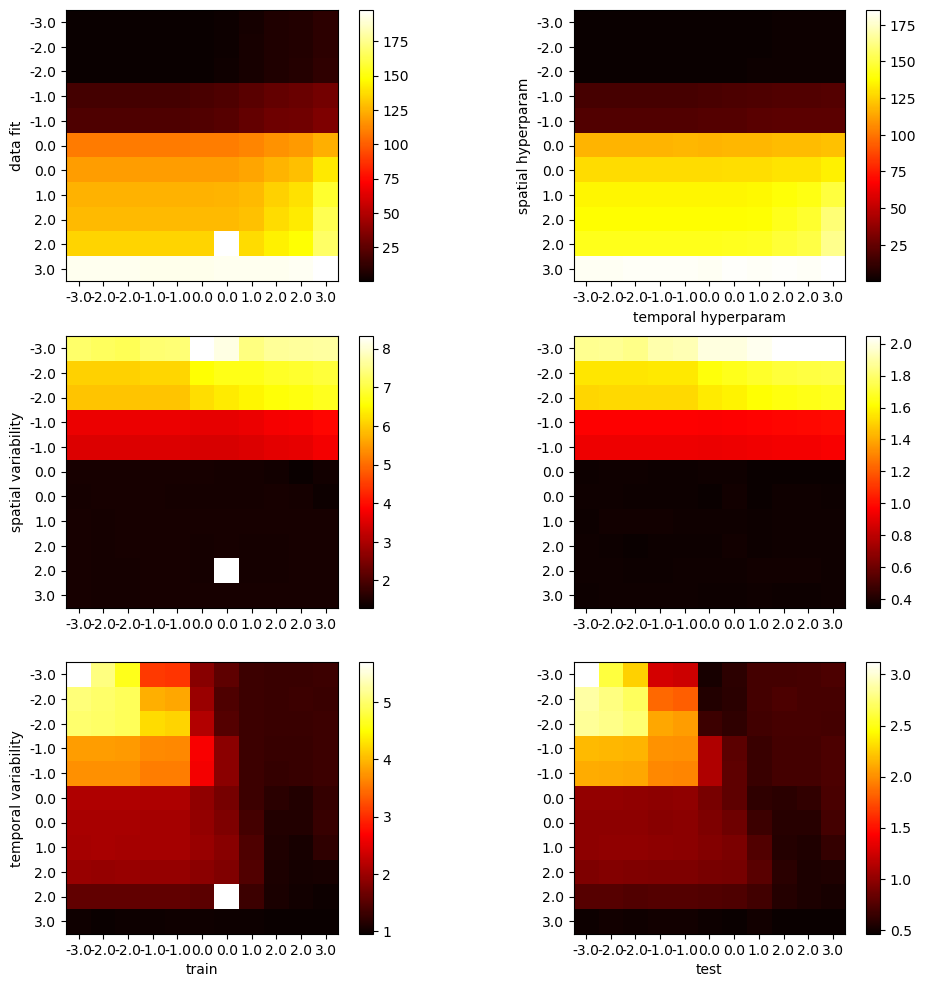

In [959]:
fig, ax = plt.subplots(3,2, figsize=(12,12))
logtype = ['logs_train', 'logs_test'] ; losstype = ['gen_loss', 'spatial_reg_loss', 'temporal_reg_loss']
scalinglog = [train_size, region_ftimecourse.shape[-1] - train_size]
scalingloss = [1, (bundle_opt.shape[0] * meandeg), 1]

for j in range(len(losstype)):
    for k in range(len(logtype)):
        if losstype[j]=='spatial_reg_loss':
            im = ax[j,k].imshow(np.array([infos[logtype[k]][d][losstype[j]][-1]
                                      for d in range(len(hyperparam_grid))]).reshape(11,11) / scalingloss[j], cmap='hot')
        else:
            im = ax[j,k].imshow(np.array([infos[logtype[k]][d][losstype[j]][-1]
                                      for d in range(len(hyperparam_grid))]).reshape(11,11) / scalingloss[j] / scalinglog[k], cmap='hot')
        

        if j == 0 and k == 1:
            ax[j,k].set_ylabel('spatial hyperparam')
            ax[j,k].set_xlabel('temporal hyperparam')
        
        if j == 2 and k == 0: ax[j,k].set_xlabel('train')
        if j == 2 and k == 1: ax[j,k].set_xlabel('test')

        if j == 0 and k == 0: ax[j,k].set_ylabel('data fit')
        if j == 1 and k == 0: ax[j,k].set_ylabel('spatial variability')
        if j == 2 and k == 0: ax[j,k].set_ylabel('temporal variability')

        ax[j,k].set_xticks(np.arange(len(grid1d)))
        ax[j,k].set_xticklabels(np.round(np.log10(grid1d)))
        ax[j,k].set_yticks(np.arange(len(grid1d)))
        ax[j,k].set_yticklabels(np.round(np.log10(grid1d)))

        plt.colorbar(im, ax=ax[j, k])

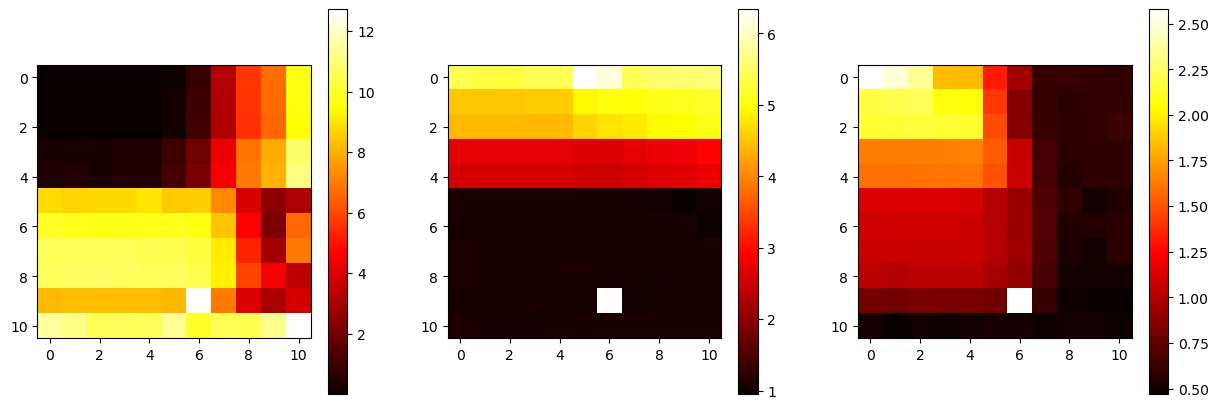

In [770]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
diffs = []
for k in range(3):
    if k == 1:
        tmp1 = np.array([infos[logtype[0]][d][losstype[k]][-1] for d in range(len(hyperparam_grid))]).reshape(11,11) / scalingloss[k]
        tmp2 = np.array([infos[logtype[1]][d][losstype[k]][-1] for d in range(len(hyperparam_grid))]).reshape(11,11) / scalingloss[k]
    else:
        tmp1 = np.array([infos[logtype[0]][d][losstype[k]][-1] for d in range(len(hyperparam_grid))]).reshape(11,11) / scalinglog[0] / scalingloss[k]
        tmp2 = np.array([infos[logtype[1]][d][losstype[k]][-1] for d in range(len(hyperparam_grid))]).reshape(11,11) / scalinglog[1] / scalingloss[k]
    
    cur_diff = np.abs(tmp1 - tmp2)
    im = ax[k].imshow(cur_diff, cmap='hot')
    plt.colorbar(im, ax=ax[k])

    diffs.append(cur_diff)

FC Comparison

In [932]:
def FC(a):
    correlation_measure = ConnectivityMeasure(kind='correlation', standardize=False)
    ret = correlation_measure.fit_transform(a.T[None])
    return ret[0]

fc_train_gm = FC(train_timecourse)
fc_test_gm = FC(test_timecourse)

# from scipy.optimize import curve_fit

# def objective(x, a, b):
# 	return a * x + b

# popt, _ = curve_fit(objective, fc_test_gm.flatten(), fc_train_gm.flatten())

# plt.scatter(fc_test_gm.flatten(), fc_train_gm.flatten())
# plt.plot(np.linspace(-0.4,1,1000), objective(np.linspace(-0.4,1,1000), popt[0], popt[1]), color='r')

# np.abs(objective(fc_test_gm, popt[0], popt[1]) - fc_train_gm)

In [933]:
fc_diffs = []
nb_bins_fc = []
for thresh in np.linspace(0,1, 101):
    nb_bins = (np.abs(fc_train_gm) > thresh).astype(float).sum()
    if nb_bins == 0:
        fc_diffs.append(1)
    else:
        tmptrain = (np.abs(fc_train_gm) > thresh).astype(float) * fc_train_gm
        tmptest = (np.abs(fc_test_gm) > thresh).astype(float) * fc_test_gm
        fc_diffs.append(pearsonr(tmptrain.flatten(), tmptest.flatten())[0])
    nb_bins_fc.append(nb_bins)

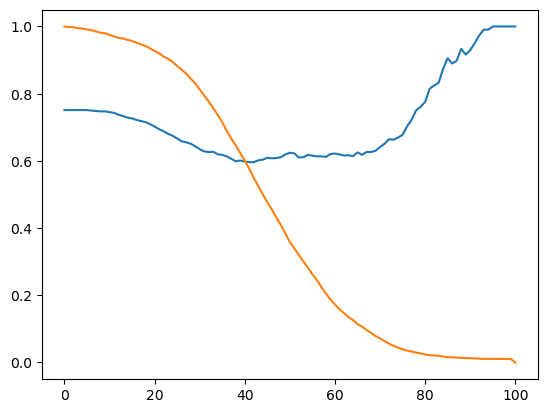

In [934]:
plt.plot(fc_diffs)
plt.plot(nb_bins_fc / np.prod(fc_train_gm.shape))

In [935]:
fc_bundles_diff = []
for nidx in tqdm(range(len(infos['bundle_train']))):
    if np.isnan(infos['bundle_train'][nidx]).sum() > 0 or np.isnan(infos['bundle_test'][nidx]).sum() > 0:
        fc_bundles_diff.append(np.nan)
        continue

    fc_train_bundle = FC(infos['bundle_train'][nidx].T)
    fc_test_bundle = FC(infos['bundle_test'][nidx].T)

    # nb_bins = (np.abs(fc_train_bundle) > 0.5).astype(float).sum()
    # tmptrain = (np.abs(fc_train_bundle) > 0.5).astype(float) * fc_train_bundle
    # tmptest = (np.abs(fc_test_bundle) > 0.5).astype(float) * fc_test_bundle

    tmptrain = (np.abs(fc_train_bundle) > 0).astype(float) * fc_train_bundle
    tmptest = (np.abs(fc_test_bundle) > 0).astype(float) * fc_test_bundle

    fc_bundles_diff.append(pearsonr(tmptrain.flatten(), tmptest.flatten())[0])

100%|██████████| 121/121 [00:57<00:00,  2.09it/s]


In [936]:
np.unravel_index(np.argsort(np.nan_to_num(fc_bundles_diff))[-5:], (grid1d.shape[0],grid1d.shape[0]))

(array([1, 1, 1, 5, 5]), array([1, 0, 2, 4, 2]))

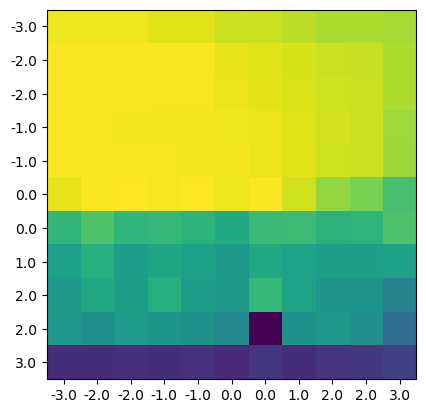

In [955]:
fig, ax = plt.subplots()
ax.imshow(np.nan_to_num(fc_bundles_diff).reshape(grid1d.shape[0],grid1d.shape[0]))
ax.set_xticks(np.arange(len(grid1d)))
ax.set_xticklabels(np.round(np.log10(grid1d)))
ax.set_yticks(np.arange(len(grid1d)))
ax.set_yticklabels(np.round(np.log10(grid1d)))
plt.show()

### Positive - Negative timecourse split

In [998]:
# spatial graph defining
bundle_graph = np.zeros((X.shape[0], X.shape[0]))
for k in range(X.shape[0]):
    avect1 = X[k]
    for s in range(X.shape[0]):
        if s == k: continue
        avect2 = X[s]
        if np.abs(avect1 - avect2).sum() <= 2:
            bundle_graph[k,s] = 1.0
            bundle_graph[s,k] = 1.0

# temporal graph defining
cycle = make_cycle(region_ftimecourse.shape[-1])

Ls = compute_directed_laplacian(bundle_graph)
Lt = compute_directed_laplacian(cycle)

In [1001]:
Xmult = np.array([X.T for _ in range(region_ftimecourse.shape[-1])])
ywhite_init = np.random.random((region_ftimecourse.shape[1], X.shape[0])) # is positive uniform distributed

positive_timecourse = region_ftimecourse * (region_ftimecourse > 0)
# Converting np arrays into Torchs
Xtorch = torch.Tensor(Xmult)
ytorch = torch.Tensor(positive_timecourse.T)

whitetorch = torch.Tensor(ywhite_init).requires_grad_(True) ; Lstorch = torch.Tensor(Ls) ; Lttorch = torch.Tensor(Lt)

bundle_opt_pos, logs_pos = optimize_lreg(whitetorch, Xtorch, ytorch, Ls=Lstorch, Lt=Lttorch, 
                                 verbose=True, num_epochs=200, logging=True, p1=1e-1, p2=1e-1, lr=1, positive_constraint=True)

100%|██████████| 200/200 [05:18<00:00,  1.59s/it]

Losses are decomposed into:
generic loss=tensor([5501.5898])
spatialloss=tensor([129153.5312])
temporalloss=tensor([1154.6235])
sumloss=tensor([18532.4062])


In [1008]:
Xmult = np.array([X.T for _ in range(region_ftimecourse.shape[-1])])
ywhite_init = np.random.random((region_ftimecourse.shape[1], X.shape[0])) # is positive uniform distributed

negative_timecourse = region_ftimecourse * (region_ftimecourse < 0)
# Converting np arrays into Torchs
Xtorch = torch.Tensor(Xmult)
ytorch = - torch.Tensor(negative_timecourse.T) # Flip sign for optimizer

whitetorch = torch.Tensor(ywhite_init).requires_grad_(True) ; Lstorch = torch.Tensor(Ls) ; Lttorch = torch.Tensor(Lt)

bundle_opt_neg, logs_neg = optimize_lreg(whitetorch, Xtorch, ytorch, Ls=Lstorch, Lt=Lttorch, 
                                 verbose=True, num_epochs=200, logging=True, p1=1e-1, p2=1e-1, lr=1, positive_constraint=True)

100%|██████████| 200/200 [05:09<00:00,  1.55s/it]

Losses are decomposed into:
generic loss=tensor([5688.8184])
spatialloss=tensor([125548.0391])
temporalloss=tensor([965.6348])
sumloss=tensor([18340.1855])


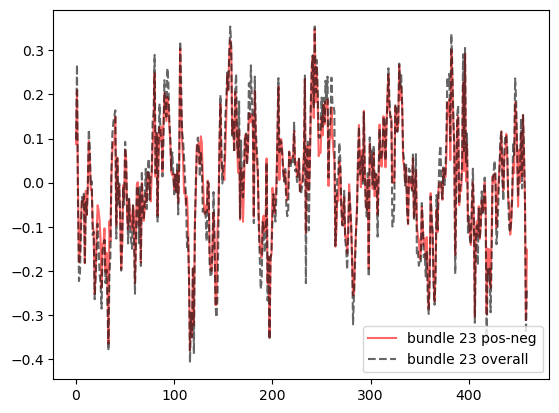

In [1040]:
plt.plot((bundle_opt_pos - bundle_opt_neg)[:,23], alpha=0.6, label='bundle 23 pos-neg', c='r')
plt.plot((bundle_opt)[:,23], alpha=0.6, linestyle='--', label='bundle 23 overall', c='k')
plt.legend()


0.014698651907351434
0.014454749716428678


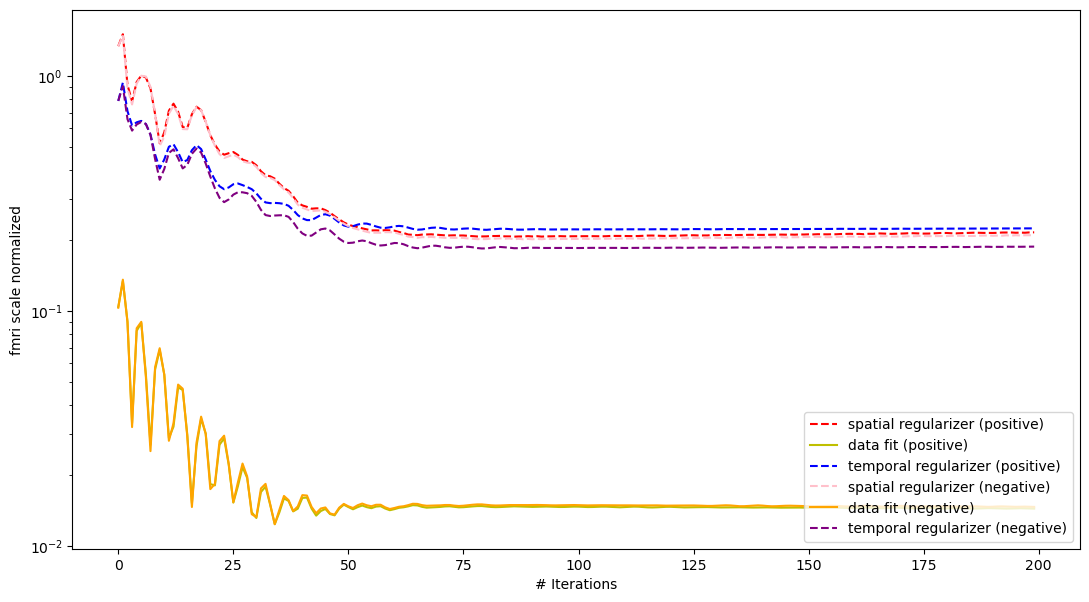

In [1009]:
scalenorm = np.abs(region_ftimecourse).mean()
meandeg = bundle_graph.sum(axis=0).astype(float).mean()

datafit_loss_pos = np.sqrt(np.array(logs_pos['gen_loss'])) / region_ftimecourse.shape[-1] / scalenorm
spatial_reg_loss_pos = np.array(logs_pos['spatial_reg_loss']) / (bundle_opt.shape[0] * meandeg) / scalenorm 
temporal_reg_loss_pos = np.array(logs_pos['temporal_reg_loss']) / region_ftimecourse.shape[-1] / scalenorm

datafit_loss_neg = np.sqrt(np.array(logs_neg['gen_loss'])) / region_ftimecourse.shape[-1] / scalenorm
spatial_reg_loss_neg = np.array(logs_neg['spatial_reg_loss']) / (bundle_opt.shape[0] * meandeg) / scalenorm 
temporal_reg_loss_neg = np.array(logs_neg['temporal_reg_loss']) / region_ftimecourse.shape[-1] / scalenorm

time_horizon = 200
plt.figure(figsize=(13,7))
plt.plot(spatial_reg_loss_pos[:time_horizon], color='r', linestyle='--', label='spatial regularizer (positive)')
plt.plot(datafit_loss_pos[:time_horizon], color='y', label='data fit (positive)')
plt.plot(temporal_reg_loss_pos[:time_horizon], color='b', linestyle='--', label='temporal regularizer (positive)')

plt.plot(spatial_reg_loss_neg[:time_horizon], color='pink', linestyle='--', label='spatial regularizer (negative)')
plt.plot(datafit_loss_neg[:time_horizon], color='orange', label='data fit (negative)')
plt.plot(temporal_reg_loss_neg[:time_horizon], color='purple', linestyle='--', label='temporal regularizer (negative)')
plt.legend(loc='lower right')
plt.yscale('log')
plt.ylabel('fmri scale normalized')
plt.xlabel('# Iterations')
print(datafit_loss_neg[-1])
print(datafit_loss_pos[-1])

### Reconstruction of the fMRI timecourses in WM bundles / voxels levels

- Bring back the GM voxel level timecourses
- Assign timecourse value on voxel being the weighted value of a voxel (so can regenerate WM volumes first then average)
- Recompute the seed connectivity of a given region versus all and show it on the volume (voxel levels)

In [73]:
bundle_affine = np.array(hf.get('header').get('affine'))[()]
tmp = nib.load('../atlas_data/rstfMRI_eg/movie_group_fmri.nii')
vdim = tmp.shape[:3]
rest_affine = tmp.affine

Making Access easier - transforming bundles to fmri coordinates / fmri volumes masks

In [74]:
trans_affine = np.matmul(np.linalg.inv(rest_affine), bundle_affine)

fmri_coords = []
for k in tqdm(range(len(bundles_labels))):
    i,j = bundles_labels[k]
    streamline = get_bundles_betweenreg(hf, i,j)
    streamline = streamline[streamline[:,3] >= thresh_subjapp]

    # Transform voxel indexes of a volume to voxel index of another volume
    volcoords_interest = volcoord2mnicoord(streamline[:,[0,1,2]], trans_affine).astype(int)
    volcoords_interest = np.concatenate([volcoords_interest, streamline[:,[3]]/nsubject], axis=1)

    fmri_coords.append(volcoords_interest)

# Save the space coords matching
save('./resources/scale1_fmri2atlas_coords_div{}.pkl'.format(int(np.ceil(thresh_subjapp))), fmri_coords)

  0%|          | 0/2586 [00:00<?, ?it/s]

100%|██████████| 2586/2586 [00:51<00:00, 49.95it/s] 


In [75]:
fmri_coords = load('./resources/scale1_fmri2atlas_coords_div{}.pkl'.format(int(np.ceil(thresh_subjapp))))

#### Load optimized white bundles

In [76]:
perf_lasso = load(f"./resources/weight_regressors_activity/bundle_activity_lasso{thresh_subjapp}.pkl")
perf_ridge = load(f"./resources/weight_regressors_activity/bundle_activity_ridge{thresh_subjapp}.pkl")
bundle_opt = load(f"./resources/weight_regressors_activity/bundle_activity_timevertex{thresh_subjapp}.pkl")
bundle_opt_saturate = load(f"./resources/weight_regressors_activity/bundle_activity_timevertex_saturate{thresh_subjapp}.pkl")

#### Interpolate the connectivity of WM bundles at voxel levels

In [77]:
def interpolate_activity(fmri_bundles, bundles_ij, rcomb, dim, normalizing=True, wmmask=None, verbose=True, probaflag=False):
    """
    Interpolates fMRI activity along fiber bundles into a 3D volume.

    Args:
    fmri_bundles: List of 3D arrays, each array is a fMRI timeseries for a bundle
    bundles_ij: List of tuples, each tuple is a pair of connected bundles 
    rcomb: Combination weights for bundles
    dim: Dimensions of output volume
    normalizing: Whether to normalize voxel values 
    wmmask: Optional white matter mask
    verbose: Whether to print progress

    Returns:
    wm_inpainted: 3D volume with interpolated fMRI signal
    wm_inpainted_masked: Masked version restricted to white matter
    """

    # Iterate across all the bundles and populate each voxels by the timcourses
    wm_inpainted = np.zeros(dim)
    wm_inpainted_masked = None
    normalizing_matrix = np.zeros(dim) # Count number of times a voxel belonged to a bundle to average out
    for k in tqdm(range(len(bundles_ij)), disable=not verbose):

        volcoords_interest = fmri_bundles[k]
        for coord in volcoords_interest:
            x,y,z,a = coord
            x,y,z = int(x),int(y),int(z)
            if probaflag:
                wm_inpainted[x,y,z] = wm_inpainted[x,y,z] + a * rcomb[k]
            else:
                wm_inpainted[x,y,z] = wm_inpainted[x,y,z] + rcomb[k]
            # normalizing_matrix[x,y,z] = normalizing_matrix[x,y,z] + np.abs(rcomb[k])
            normalizing_matrix[x,y,z] = normalizing_matrix[x,y,z] + 1.0

    normalizing_matrix[normalizing_matrix == 0] = np.inf
    if normalizing:
        wm_inpainted = wm_inpainted/np.abs(normalizing_matrix)    

    # Out of bound encoding for backgrounds
    wm_inpainted[wm_inpainted == 0] = -100000

    if not wmmask is None:
        # Apply a white matter mask if we care only about correct bundle masking
        wm_inpainted_masked = wm_inpainted * wmmask
        wm_inpainted_masked[wm_inpainted_masked == 0] = -100000
    
    return wm_inpainted, wm_inpainted_masked

In [78]:
# wm_inpainted_lasso, wm_inpainted_lassoM = interpolate_activity(fmri_coords, bundles_labels, np.array(perf_lasso['coefs'])[0,1], vdim, wmmask=wm_mask_subj, normalizing=True)
# wm_inpainted_ridge, wm_inpainted_ridgeM = interpolate_activity(fmri_coords, bundles_labels, np.array(perf_ridge['coefs'])[0,1], vdim, wmmask=wm_mask_subj, normalizing=True)


wm_inpainted_lreg, wm_inpainted_lregM = interpolate_activity(fmri_coords, bundles_labels, bundle_opt[0], vdim, wmmask=wm_mask_subj, normalizing=True)
wm_inpainted_lsat, wm_inpainted_lsatM = interpolate_activity(fmri_coords, bundles_labels, bundle_opt_saturate[0], vdim, wmmask=wm_mask_subj, normalizing=True)
# wm_inpainted_lpos, wm_inpainted_lposM = interpolate_activity(fmri_coords, bundles_labels, bundle_opt_pos[0], vdim, wmmask=wm_mask_subj, normalizing=True)
# wm_inpainted_lneg, wm_inpainted_lnegM = interpolate_activity(fmri_coords, bundles_labels, bundle_opt_neg[0], vdim, wmmask=wm_mask_subj, normalizing=True)
# wm_inpainted_lall, wm_inpainted_lallM = interpolate_activity(fmri_coords, bundles_labels, bundle_opt_pos[0] - bundle_opt_neg[0], vdim, wmmask=wm_mask_subj, normalizing=True)

100%|██████████| 2586/2586 [00:42<00:00, 61.25it/s] 


#### Comparing inpainting models (display only wm bundles of interest)

In [49]:
frame0 = zscore(region_ftimecourse[:,0])/3
gm_activity_voxels = np.sum([frame0[k] * regions_in_voxels[:,:,:,k] for k in range(nb_regions)],axis=0)
gm_activity_voxels[gm_activity_voxels==0] = -100

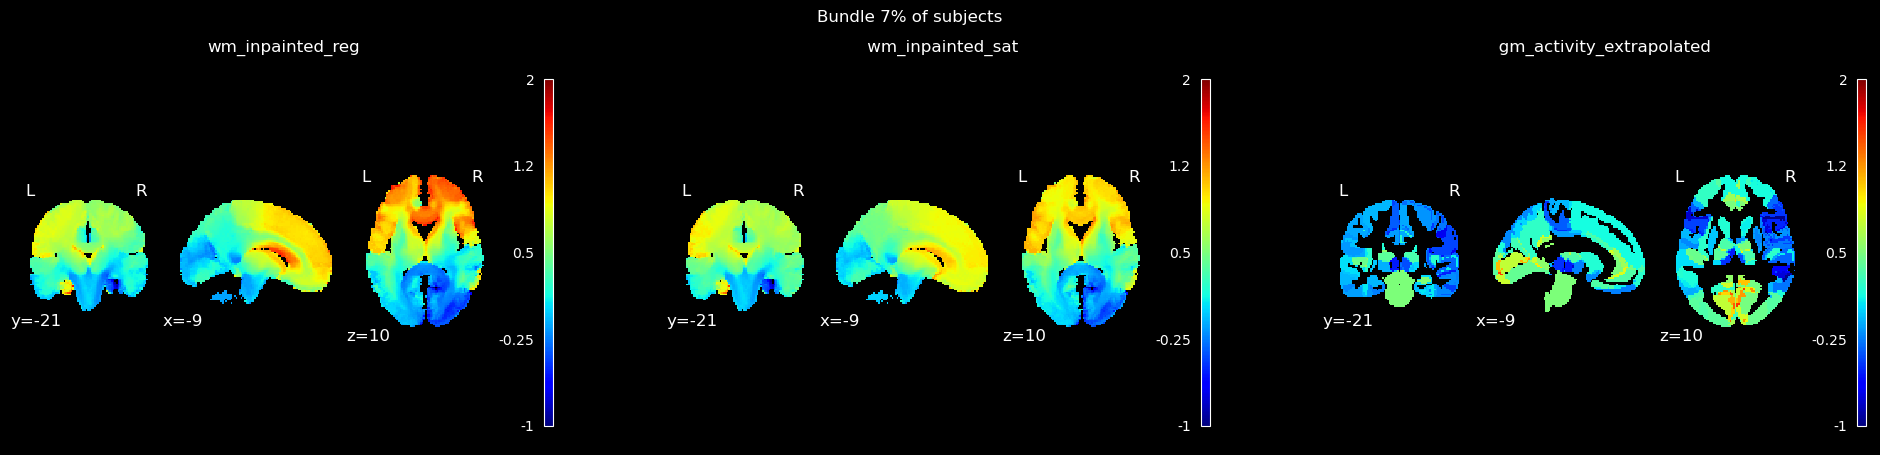

In [107]:
# inpaint_mods = [wm_inpainted_lassoM, wm_inpainted_ridgeM,   wm_inpainted_lregM]
# all_inpaints_names = f'wm_inpainted_lasso (masked - tidx={1}), wm_inpainted_ridge (masked - tidx={1}),   wm_inpainted_reg (masked - tidx={1})'.split(',')

inpaint_mods = [wm_inpainted_lreg, wm_inpainted_lsat, gm_activity_voxels]
all_inpaints_names = f'wm_inpainted_reg, wm_inpainted_sat,   gm_activity_extrapolated'.split(',')

affines = [rest_affine] * 3
coords_of_interest = [(-9,-21,10)] * 3
plot_compare_inpainting(inpaint_mods, coords_of_interest, affines, all_inpaints_names, vmin=-1, vmax=2)

#### Compute areas of good correlation against gray matter of each models

In [82]:
tmparray_lreg = []
for k in tqdm(range(bundle_opt.shape[0])):
    tmp_inpainted, tmp_inpainted2 = interpolate_activity(fmri_coords, bundles_labels, bundle_opt[k], vdim, wmmask=wm_mask_subj, normalizing=True, verbose=False)
    tmparray_lreg.append(tmp_inpainted)
tmparray_lreg = np.array(tmparray_lreg)

100%|██████████| 460/460 [5:33:58<00:00, 43.56s/it]    


In [84]:
tmparray_gm = []
for tidx in tqdm(range(bundle_opt.shape[0])):
    frame0 = zscore(region_ftimecourse[:,tidx])/3
    gm_activity_voxels = np.sum([frame0[k] * regions_in_voxels[:,:,:,k] for k in range(nb_regions)],axis=0)
    gm_activity_voxels[gm_activity_voxels==0] = -100
    tmparray_gm.append(gm_activity_voxels)
tmparray_gm = np.array(tmparray_gm)

100%|██████████| 460/460 [03:05<00:00,  2.49it/s]


In [97]:
similarity_space = np.zeros((tmparray_gm.shape[1:]))
for x in range(similarity_space.shape[0]):
    for y in range(similarity_space.shape[1]):
        for z in range(similarity_space.shape[2]):
            similarity_space[x,y,z] = pearsonr(tmparray_gm[:,x,y,z], tmparray_lreg[:, x,y,z])[0]

/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [103]:
similarity_space = np.nan_to_num(similarity_space)
similarity_space[similarity_space==0] = -100

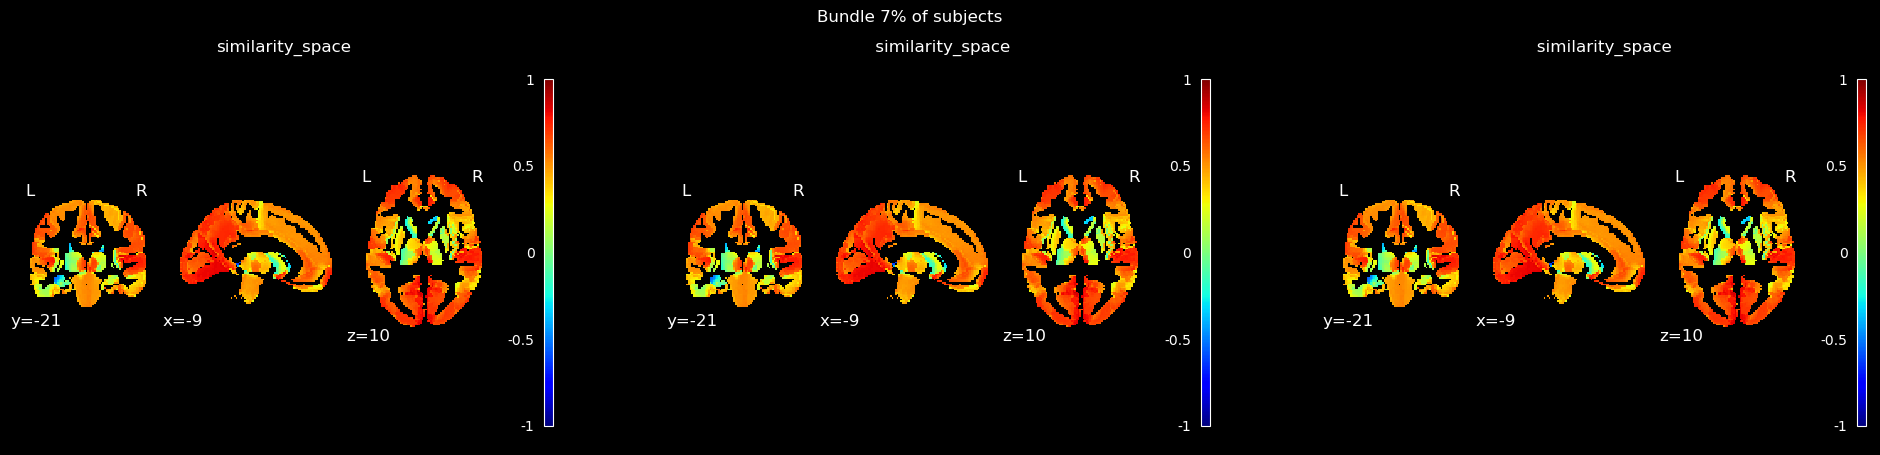

In [106]:
inpaint_mods = [similarity_space, similarity_space, similarity_space]
all_inpaints_names = f'similarity_space, similarity_space,   similarity_space'.split(',')

affines = [rest_affine] * 3
coords_of_interest = [(-9,-21,10)] * 3
plot_compare_inpainting(inpaint_mods, coords_of_interest, affines, all_inpaints_names, vmin=-1, vmax=1)

In [ ]:
# Using these 3 metrics we compare the goodness of spatial datafit
linegraph_degree = np.sum(bundle_graph, axis=0)
nbstlines_bundles = np.array([nbStlines_view[i-1,j-1] for (i,j) in bundles_labels])
avglength_bundles = np.array([length_view[i-1,j-1] for (i,j) in bundles_labels])

In [178]:
linegraph_vol = []
nbstlines_vol = []
avglength_vol = []
for k in tqdm(range(len(fmri_coords))):
    tmp1 = np.zeros_like(similarity_space)
    tmp2 = np.zeros_like(similarity_space)
    tmp3 = np.zeros_like(similarity_space)
    map_k = fmri_coords[k][:,:3].astype(int)
    for coord in map_k:
        tmp1[coord[0], coord[1], coord[2]] = linegraph_degree[k]
        tmp2[coord[0], coord[1], coord[2]] = nbstlines_bundles[k]
        tmp3[coord[0], coord[1], coord[2]] = avglength_bundles[k]
    
    linegraph_vol.append(tmp1)
    nbstlines_vol.append(tmp2)
    avglength_vol.append(tmp3)

linegraph_vol = np.array(linegraph_vol).mean(axis=0)
nbstlines_vol = np.array(nbstlines_vol).mean(axis=0)
avglength_vol = np.array(avglength_vol).mean(axis=0)

100%|██████████| 2586/2586 [00:50<00:00, 50.89it/s] 


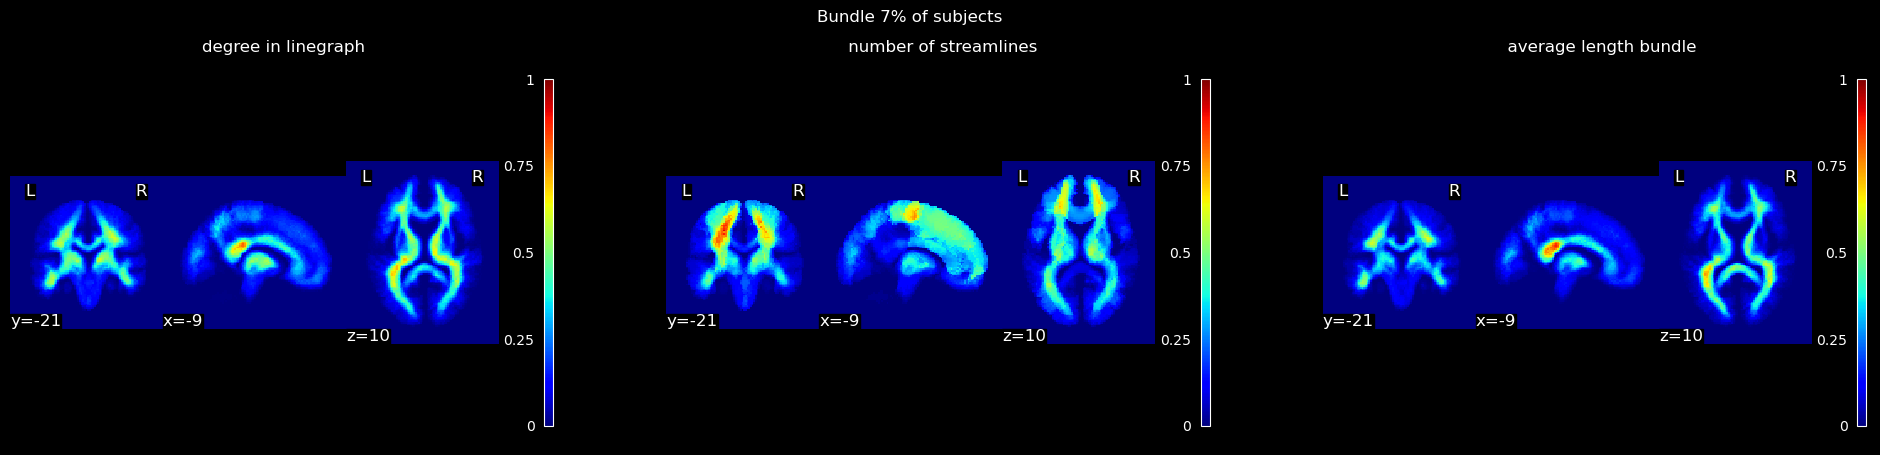

In [179]:
inpaint_mods = [linegraph_vol / linegraph_vol.max(), nbstlines_vol / nbstlines_vol.max(), avglength_vol / avglength_vol.max()]
all_inpaints_names = f'degree in linegraph, number of streamlines,  average length bundle'.split(',')

affines = [rest_affine] * 3
coords_of_interest = [(-9,-21,10)] * 3
plot_compare_inpainting(inpaint_mods, coords_of_interest, affines, all_inpaints_names, vmin=0, vmax=1)

#### Compute the pcc  with inpainting models

In [644]:
### Compute the pcc seed connectivity
# Load the rest fmri in MNI space volumes
ftimecourse = nib.load('../atlas_data/rstfMRI_eg/movie_group_fmri.nii').get_fdata()

connFilename = '../atlas_data/fiber_atlas/probconnatlas/wm.connatlas.scale1.h5'
hf = h5py.File(connFilename, 'r')

centers = np.array(hf.get('header').get('gmcoords'))

gmregions_names = hf.get('header').get('gmregions')[()]
# use the masks if necessary when we select too much bundles for reconstruction
gm_mask_subj = nib.load('../atlas_data/rstfMRI_eg/gm_mask_subj7.nii').get_fdata()
wm_mask_subj = (gm_mask_subj + 1) % 2

region_of_interest = ['ctx-rh-posteriorcingulate', 'ctx-lh-posteriorcingulate']
index_of_interest = [np.where(gmregions_names.astype(str) == r)[0][0] 
                     for r in region_of_interest]

index_of_interest = np.array(index_of_interest)

# Visualize the corresponding probabilstic voxels for this region
root = '../atlas_data/fiber_atlas/yasser_datacomp/volspams_compress/'

atlas_of_interest = 'compresslausanne2018.scale1.sym.corrected.ctx+subc.volspams.nii.gz'

prob_regions, prob_affine = (nib.load(root + atlas_of_interest).get_fdata(), nib.load(root + atlas_of_interest).affine)

# threshold the prob_regions into binary mask
thresh = 0.1  # empirically chosen thresh to have at least 3 subjects overlap on that region
mask_regions = (prob_regions > thresh).astype(float)

rmask_regions_nifti = nimg.resample_to_img(nib.Nifti1Image(mask_regions, affine=prob_affine), 
                                           nib.Nifti1Image(ftimecourse[:,:,:,0], affine=rest_affine), interpolation = 'nearest')
rmask_regions = rmask_regions_nifti.get_fdata()

In [645]:
from scipy.ndimage import gaussian_filter1d

tmp = np.concatenate([ftimecourse[rmask_regions[:,:,:,k + 1].astype(bool)] for k in index_of_interest])
movie_mean = np.mean([gaussian_filter1d(tmp[k],1.2) for k in range(len(tmp))],axis=0)

tmparray_lasso = []
for k in tqdm(range(ftimecourse.shape[-1])):
    tmp_inpainted, tmp_inpainted2 = interpolate_activity(fmri_coords, bundles_labels, bundle_opt[k], vdim, wmmask=wm_mask_subj, normalizing=True, verbose=False)
    tmparray_lasso.append(tmp_inpainted)
tmparray_lasso = np.array(tmparray_lasso)

# seed functional connectivity on PCC
seedfunc_vol_lasso = np.zeros((ftimecourse.shape[:-1]))
for x in tqdm(range(seedfunc_vol_lasso.shape[0])):
    for y in range(seedfunc_vol_lasso.shape[1]):
        for z in range(seedfunc_vol_lasso.shape[2]):
            seedfunc_vol_lasso[x,y,z] = pearsonr(movie_mean, tmparray_lasso[:,x,y,z])[0]

  0%|          | 0/91 [00:00<?, ?it/s]/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
100%|██████████| 91/91 [00:56<00:00,  1.61it/s]


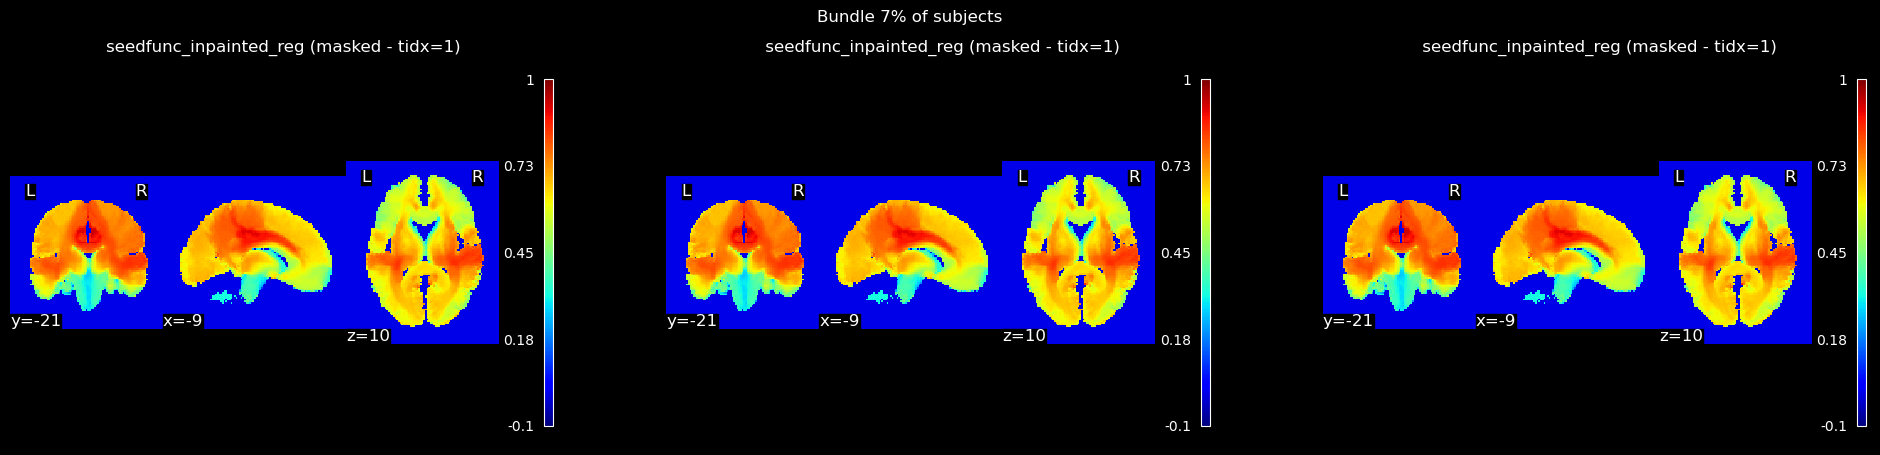

In [649]:
inpaint_mods = [seedfunc_vol_lasso, seedfunc_vol_lasso, seedfunc_vol_lasso]

all_inpaints_names = f'seedfunc_inpainted_reg (masked - tidx={1}), seedfunc_inpainted_reg (masked - tidx={1}), seedfunc_inpainted_reg (masked - tidx={1})'.split(',')

affines = [rest_affine] * 3
coords_of_interest = [(-9,-21,10)] * 3
plot_compare_inpainting(inpaint_mods, coords_of_interest, affines, all_inpaints_names, vmin=-0.1, vmax=1)

In [ ]:
# NOTE: Close the opened h5 file
hf.close()